In this notebook I implement the logistic regression. The dataset used is avalable in [kaggle](https://www.kaggle.com/datasets/prathamtripathi/drug-classification) and represents the use of two types of drug, with features of users.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
from tabulate import tabulate
import math

In [2]:
connection = sqlite3.connect('data/Drug.db')
cursor = connection.cursor()

In [ ]:
df = pd.read_csv('data/drug200.csv')
df_sql = df.to_sql('drug', con=connection, if_exists='append', index=False)

In [4]:
schema = cursor.execute('SELECT sql FROM sqlite_master').fetchall()
print(tabulate(schema))

---------------------
CREATE TABLE "drug" (
"Age" INTEGER,
  "Sex" TEXT,
  "BP" TEXT,
  "Cholesterol" TEXT,
  "Na_to_K" REAL,
  "Drug" TEXT
)
---------------------


In [3]:
cursor.execute("SELECT *  from drug")
data = np.array(cursor.fetchall())
print(tabulate(data[:10]))

#F = 1 and M = 0
#HIGH = 1  and LOW = NORMAL = 0
# X = data[:,1:4]
# X[X == 'HIGH'] = 1
# X[X == 'LOW'] = 0
# X[X == 'NORMAL'] = 0
# X[X == 'F'] = 1
# X[X == 'M'] = 0
X = data[:,0::4]
X = X.astype(np.float64)
y = data[:,-1]
y[y == 'DrugY'] = 0
y[y == 'drugX'] = 0
y[y == 'drugC'] = 1
y[y == 'drugB'] = 1
y[y == 'drugA'] = 1
y = y.astype(np.float64)

--  -  ------  ------  ------  -----
23  F  HIGH    HIGH    25.355  DrugY
47  M  LOW     HIGH    13.093  drugC
47  M  LOW     HIGH    10.114  drugC
28  F  NORMAL  HIGH     7.798  drugX
61  F  LOW     HIGH    18.043  DrugY
22  F  NORMAL  HIGH     8.607  drugX
49  F  NORMAL  HIGH    16.275  DrugY
41  M  LOW     HIGH    11.037  drugC
60  M  NORMAL  HIGH    15.171  DrugY
43  M  LOW     NORMAL  19.368  DrugY
--  -  ------  ------  ------  -----


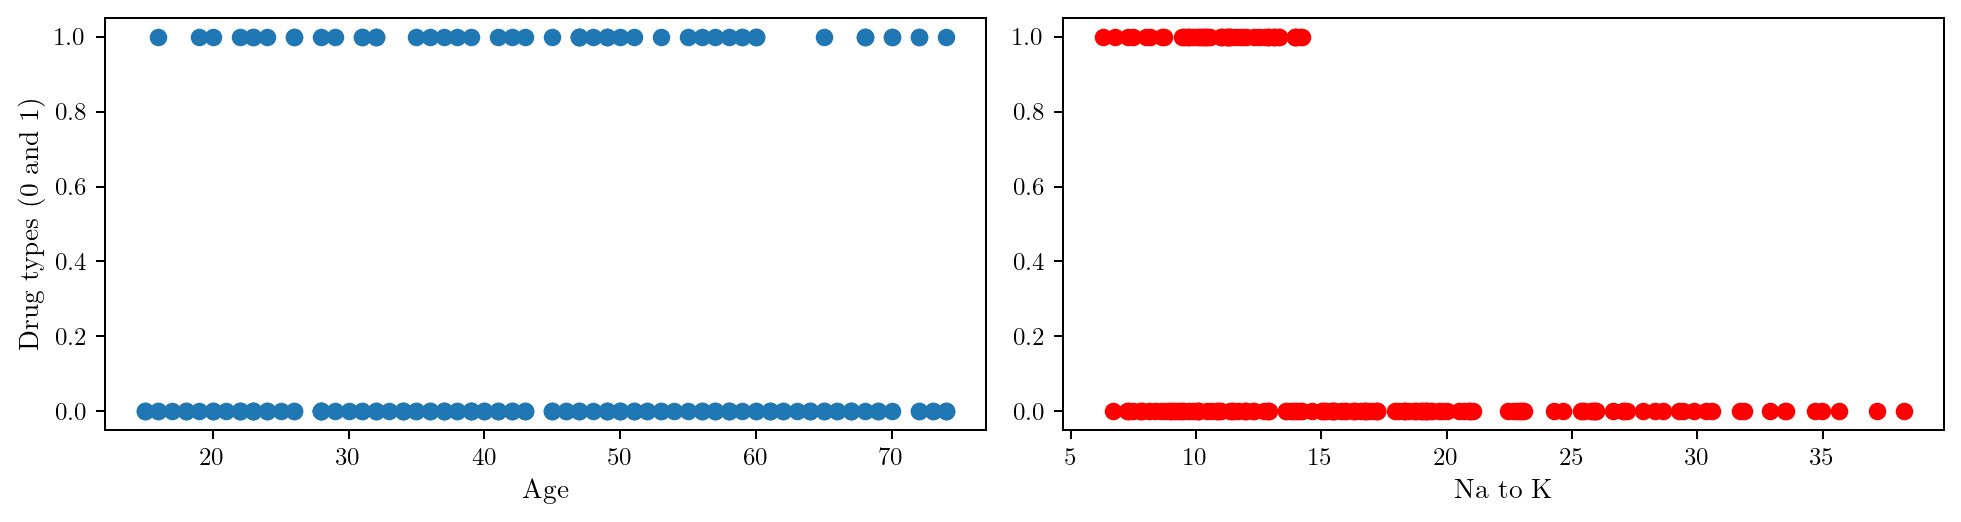

In [398]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11,3), dpi=180)
ax1.scatter(X[:,0], y)
ax2.scatter(X[:,1],y,c='r')

pt = 11
ax1.set_xlabel(r'Age',fontsize=pt)
ax2.set_xlabel(r'Na to K',fontsize=pt)
ax1.set_ylabel(r'Drug types (0 and 1)',fontsize=pt)
plt.tight_layout()
plt.show()

$$J(\vec{X},\vec{w},b) = \frac{1}{2m} \sum_{i=0}^{m-1} (f_{\vec{w}b}(\vec{X}^{(i)}) - y^{(i)})^2 = \frac{1}{m} \sum_{i=0}^{m-1} L(f_{\vec{w}b},\vec{X}^{(i)}) $$

$$f_{\vec{w}b} = g(z) = \frac{1}{1+e^{-z}}$$

$$z = \vec{w}  \vec{X} + b$$

In [4]:
def scale_z_score(x_train):
    mean = np.mean(x_train,axis=0)
    sigma = np.std(x_train,axis=0)
    x_scaled = (x_train - mean)/sigma
    return x_scaled, mean, sigma

Xs, mean, sigma = scale_z_score(X)

In [5]:
def sigmoid(z):
    z = np.clip(z, -700, 700)
    g = 1/(1+np.exp(-z))
    return g

In [6]:
def cost_regularized(X, y, w, b, lambda_):
    m,n = X.shape

    cost = 0
    w_sum = 0
    for i in range(m):
        z = np.dot(X[i],w) + b
        f_wb_i = sigmoid(z)
        f_wb_i = np.clip(f_wb_i, 1e-300,1)
        diff = 1-f_wb_i
        diff = np.clip(diff, 1e-300,1)
        cost += -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(diff)
    total_cost = 1/m*cost

    #regularization to avoid overfitting
    w_sum = np.sum(w**2)
    reg = lambda_/(2*m) * w_sum
    total_cost += reg
    
    return total_cost

In [7]:
def gradient_regularized(X, y, w, b, lambda_):
    m,n = X.shape
    
    dj_dw = np.zeros(n)
    dj_db = 0

    for i in range(m):
        z_i = np.dot(X[i],w) + b
        f_wb_i = sigmoid(z_i)
        for j in range(n):
            dj_dw_i = (f_wb_i - y[i]) * X[i,j]
            dj_dw[j] += dj_dw_i
        dj_db_i = f_wb_i - y[i]
        dj_db += dj_db_i
    
    dj_dw = 1/m*dj_dw
    dj_db = 1/m*dj_db

    for j in range(n):
        dj_dw[j] += lambda_/m * w[j]

    return dj_dw, dj_db

In [8]:
def gradient_descent(X, y, w, b, alpha, lambda_, n_iter):
    m,n = X.shape

    J_hist = []
    w_hist = []
    b_hist = []

    for k in range(n_iter):
        dj_dw, dj_db = gradient_regularized(X, y, w, b, lambda_)

        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        J_hist.append(cost_regularized(X, y, w, b, lambda_))
        w_hist.append(w)
        b_hist.append(b)

        if k % math.ceil(n_iter/10) == 0:
            print(f'Iteration {k:4d}: Cost {J_hist[-1]}')
    return w, b, J_hist, w_hist, b_hist

In [45]:
m,n = X.shape
w_init = np.zeros(n)
b_init = 2.5
alpha = 1e-3
lambda_ = 0.5

w, b, J_hist, w_hist, b_hist = gradient_descent(X, y, w_init, b_init, alpha, lambda_, 10000)

Iteration    0: Cost 1.0753247882811783
Iteration 1000: Cost 0.4499204404667206
Iteration 2000: Cost 0.44990803200740354
Iteration 3000: Cost 0.44990731723971356
Iteration 4000: Cost 0.4499066169119641
Iteration 5000: Cost 0.4499059270763433
Iteration 6000: Cost 0.4499052475731049
Iteration 7000: Cost 0.449904578246176
Iteration 8000: Cost 0.449903918941871
Iteration 9000: Cost 0.44990326950885295


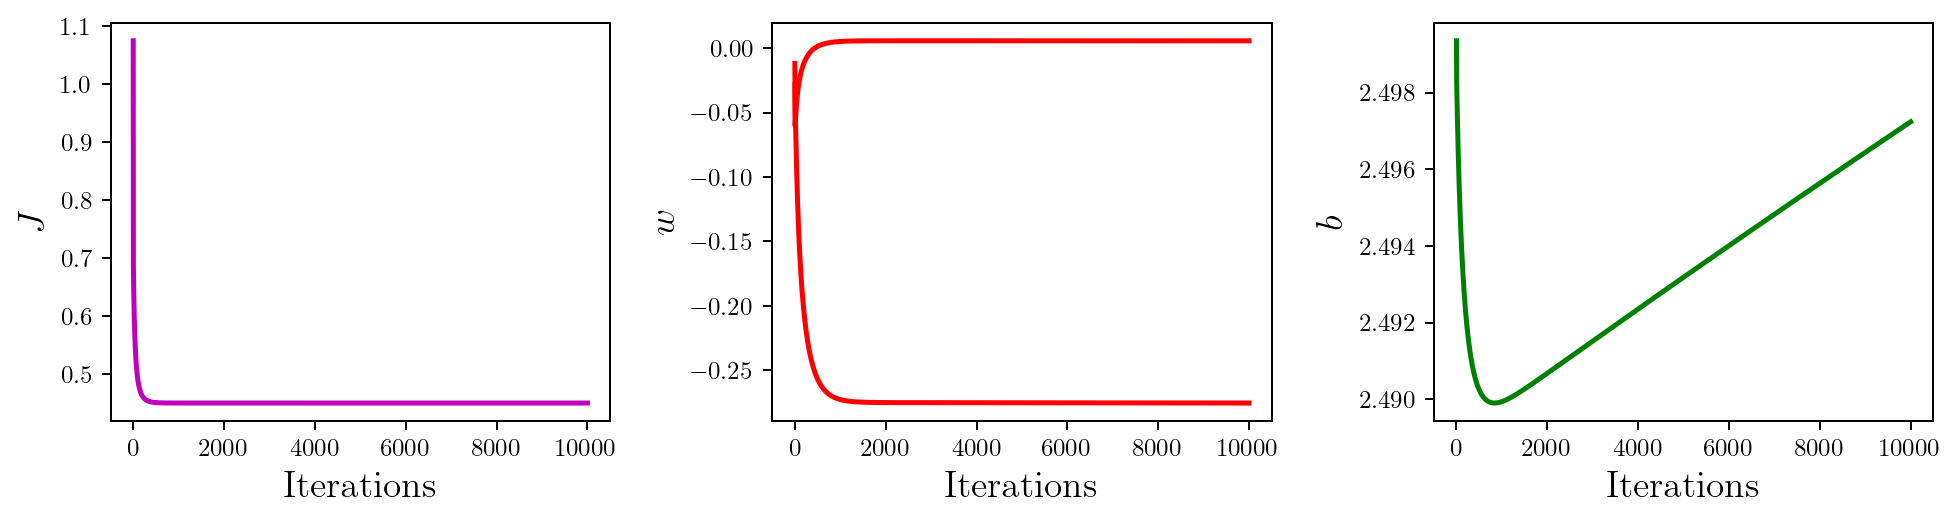

In [46]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(11,3), dpi=180)
ax1.plot(np.arange(len(J_hist)), J_hist, lw=2, c='m')
ax2.plot(np.arange(len(w_hist)), w_hist, lw=2, c='r')
ax3.plot(np.arange(len(b_hist)), b_hist, lw=2, c='g')
pt = 15

ax1.set_xlabel(r'Iterations',fontsize=pt)
ax2.set_xlabel(r'Iterations',fontsize=pt)
ax3.set_xlabel(r'Iterations',fontsize=pt)
ax1.set_ylabel(r'$J$',fontsize=pt)
ax2.set_ylabel(r'$w$',fontsize=pt)
ax3.set_ylabel(r'$b$',fontsize=pt)
plt.tight_layout()
plt.show()

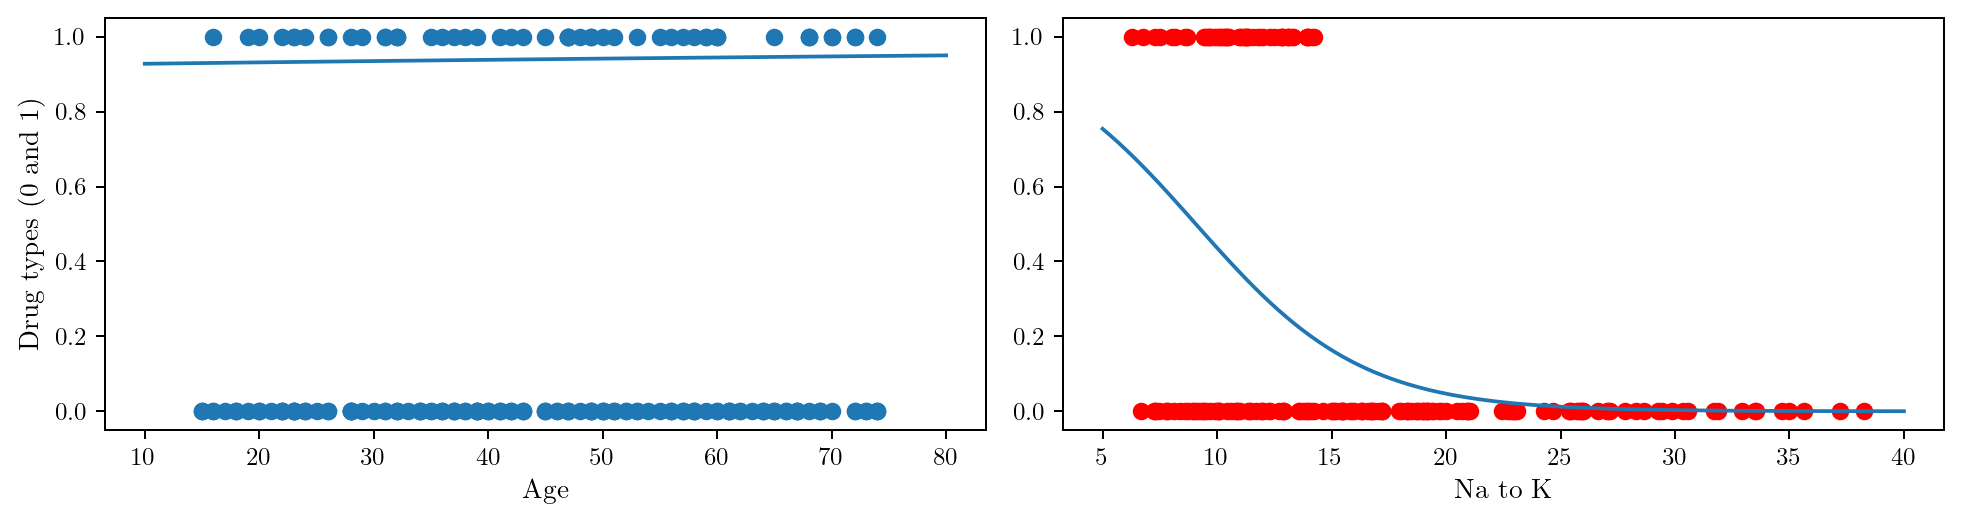

In [53]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11,3), dpi=180)

age_list = np.linspace(10,80,101)
Na_list = np.linspace(5,40,101)

ax1.scatter(X[:,0], y)
ax2.scatter(X[:,1],y,c='r')

z = w[0]*age_list + b
sig = sigmoid(z)
ax1.plot(age_list, sig)

z = w[1]*Na_list + b
sig = sigmoid(z)
ax2.plot(Na_list, sig,'-')

pt = 11
ax1.set_xlabel(r'Age', fontsize=pt)
ax2.set_xlabel(r'Na to K', fontsize=pt)
ax1.set_ylabel(r'Drug types (0 and 1)', fontsize=pt)
plt.tight_layout()
plt.show()

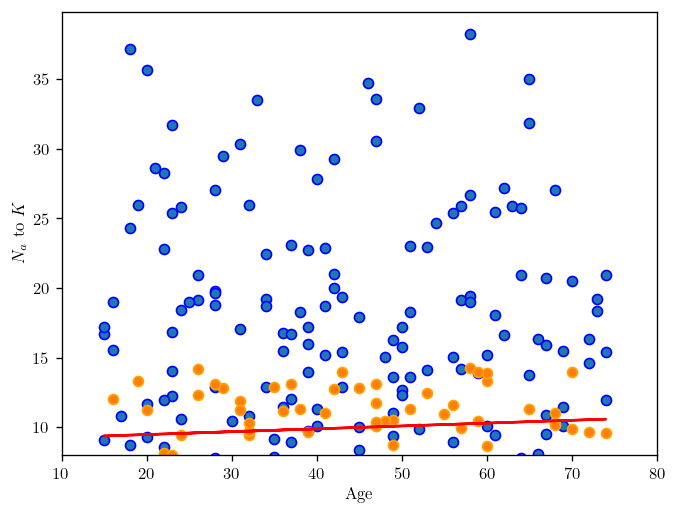

In [54]:
query1 = "SELECT Age, Na_to_K FROM Drug WHERE Drug = 'drugX' or drug = 'DrugY'"
query2 = "SELECT Age, Na_to_K FROM Drug WHERE Drug = 'drugA' or drug = 'drugB' or drug = 'drugC'"
d_xy = np.array(cursor.execute(query1).fetchall())
d_123 = np.array(cursor.execute(query2).fetchall())

age_xy = d_xy[:,0]
Na_xy = d_xy[:,1]
age_123 = d_123[:,0]
Na_123 = d_123[:,1]

# age_xy = scale_z_score(age_xy)
# Na_xy = scale_z_score(Na_xy)
# age_123 = scale_z_score(age_123)
# Na_123 = scale_z_score(Na_123)

plt.figure(dpi=120)
plt.scatter(age_xy, Na_xy, edgecolor='b')
plt.scatter(age_123, Na_123, edgecolor='orange')
plt.plot(X[:,0], -w[0]/w[1]*X[:,0] - b/w[1], 'r')
plt.xlim(10,80)
plt.ylim(8,)
plt.xlabel('Age')
plt.ylabel(r'$N_a$ to $K$')
plt.show()

For scaled features (and parameters):

In [9]:
m,n = Xs.shape
ws_init = np.zeros(n)
bs_init = 2.5
alpha = 1e-1
lambda_ = 0.5

ws, bs, J_hist, w_hist, b_hist = gradient_descent(Xs, y, ws_init, bs_init, alpha, lambda_, 10000)

Iteration    0: Cost 1.845627019521326
Iteration 1000: Cost 0.4546122533753087
Iteration 2000: Cost 0.45455131797797566
Iteration 3000: Cost 0.4545511409870201
Iteration 4000: Cost 0.4545511404434978
Iteration 5000: Cost 0.4545511404418236
Iteration 6000: Cost 0.4545511404418184
Iteration 7000: Cost 0.4545511404418182
Iteration 8000: Cost 0.4545511404418184
Iteration 9000: Cost 0.45455114044181855


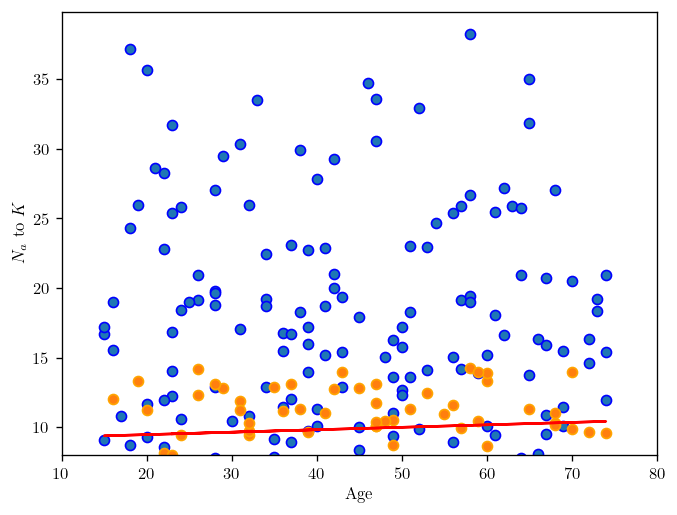

In [13]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

query1 = "SELECT Age, Na_to_K FROM Drug WHERE Drug = 'drugX' or drug = 'DrugY'"
query2 = "SELECT Age, Na_to_K FROM Drug WHERE Drug = 'drugA' or drug = 'drugB' or drug = 'drugC'"
d_xy = np.array(cursor.execute(query1).fetchall())
d_123 = np.array(cursor.execute(query2).fetchall())

age_xy = d_xy[:,0]
Na_xy = d_xy[:,1]
age_123 = d_123[:,0]
Na_123 = d_123[:,1]

b = bs - ws[0]/sigma[0]*mean[0] - ws[1]/sigma[1]*mean[1]
w = np.array([ws[0]/sigma[0], ws[1]/sigma[1]])

plt.figure(dpi=120)
plt.scatter(age_xy, Na_xy, edgecolor='b')
plt.scatter(age_123, Na_123, edgecolor='orange')
plt.plot(X[:,0], -w[0]/w[1]*X[:,0] - b/w[1], 'r')
plt.xlim(10,80)
plt.ylim(8,)
plt.xlabel('Age')
plt.ylabel(r'$N_a$ to $K$')
plt.show()